# Árbol de Steiner para Planificación de Ciclovías con QAOA

Este notebook demuestra la aplicación del **Quantum Approximate Optimization Algorithm (QAOA)** para resolver el problema del Árbol de Steiner en la planificación de ciclovías en Montevideo, Uruguay.

## Contenido
1. Introducción al problema
2. Formulación matemática QUBO
3. Carga de datos de OpenStreetMap
4. Construcción del grafo y selección de terminales
5. Implementación del algoritmo QAOA para Steiner Tree
6. Conversión a formato compatible y ejecución
7. Visualización de resultados
8. Análisis de la solución
9. Conclusiones

---

## 1. Introducción al Problema del Árbol de Steiner

El **problema del Árbol de Steiner** consiste en encontrar un subgrafo conexo de costo mínimo que conecte un conjunto de nodos obligatorios (terminales), pudiendo usar nodos intermedios opcionales (nodos de Steiner) si reducen el costo total.

### Aplicación a ciclovías en Montevideo:

En este notebook utilizamos **datos reales de ciclovías de Montevideo** extraídos de OpenStreetMap (visibles en CyclOSM):

- **Terminales (nodos rojos)**: Extremos de las ciclovías existentes en Montevideo
  - Son puntos OBLIGATORIOS que deben estar conectados
  - Representan infraestructura ciclista ya existente
  
- **Nodos Steiner (nodos azules)**: Intersecciones aleatorias de la red de calles
  - Son puntos OPCIONALES que pueden usarse
  - El algoritmo decide si incluirlos para minimizar el costo total
  
- **Objetivo**: Encontrar la red de conexión más corta que una todas las ciclovías existentes, posiblemente usando intersecciones intermedias

### Ventajas de usar QAOA:
- Exploración cuántica del espacio de soluciones
- Manejo natural de restricciones mediante penalizaciones
- Escalabilidad a problemas medianos (hasta ~30 qubits)

## 2. Formulación Matemática QUBO

### Variables de Decisión

Para cada nodo $v \in V$:
$$y_v \in \{0, 1\}$$
donde $y_v = 1$ si el nodo está activo.

Para cada arista $e = (u,v) \in E$:
$$x_e \in \{0, 1\}$$
donde $x_e = 1$ si la arista está seleccionada.

### Hamiltoniano Total

$$H_{\text{total}} = H_{\text{costo}} + H_{\text{nodos}} + H_{\text{consistencia}} + H_{\text{conectividad}} + H_{\text{árbol}}$$

#### 1. Costo de aristas
$$H_{\text{costo}} = \alpha \sum_{e \in E} w_e \cdot x_e$$

#### 2. Penalización de nodos
$$H_{\text{nodos}} = \sum_{v \in V \setminus T} p_v \cdot y_v$$

#### 3. Consistencia arista-nodo
$$H_{\text{consistencia}} = \lambda_1 \sum_{(u,v) \in E} \left[ (x_{uv} - y_u)^2 + (x_{uv} - y_v)^2 \right]$$

#### 4. Conectividad de terminales
$$H_{\text{conectividad}} = \lambda_2 \sum_{t \in T} \left( d_t - \sum_{e \in \delta(t)} x_e \right)^2$$

#### 5. Balance de árbol
$$H_{\text{árbol}} = \lambda_3 \left( 1 + \sum_{e \in E} x_e - \sum_{v \in V} y_v \right)^2$$

### Restricciones duras
$$y_t = 1, \quad \forall t \in T$$

Para más detalles, ver [QUBO_FORMULATION.md](QUBO_FORMULATION.md)

In [45]:
# Instalación de dependencias (ejecutar si es necesario)
# Descomenta y ejecuta la siguiente línea si no tienes las librerías instaladas:
# !pip install qiskit qiskit-optimization qiskit-aer networkx matplotlib osmnx folium

# Nota: OSMnx requiere datos de OpenStreetMap. Si no se pueden descargar,
# el notebook usará un grafo sintético de ejemplo.

In [49]:
# Importar librerías necesarias
import json
import logging
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import folium
from folium import plugins

# Importar librerías de Qiskit
from qiskit_optimization import QuadraticProgram

# Configurar logging
logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 3. Carga de Datos de OpenStreetMap - Montevideo

Vamos a extraer datos de una zona específica de Montevideo que incluya:
- Red de calles completa
- **Ciclovías existentes** (identificadas según CyclOSM)
- Los extremos de las ciclovías serán nuestros **nodos terminales**
- Nodos aleatorios de la red serán **candidatos Steiner**

In [51]:
# Definir área de interés en Montevideo
# Centro de Montevideo con área circundante
place_name = "Centro, Montevideo, Uruguay"
distance = 1500  # metros desde el centro

print(f"Descargando datos de OSM para {place_name}...")

try:
    # Descargar red de calles
    G_street = ox.graph_from_place(
        place_name,
        network_type='all',
        dist=distance,
        simplify=True
    )
    
    # Convertir a grafo no dirigido
    G_street = ox.convert.to_undirected(G_street)
    
    print(f"✓ Grafo descargado: {G_street.number_of_nodes()} nodos, {G_street.number_of_edges()} aristas")
    
except Exception as e:
    print(f"⚠ Error descargando datos de OSM: {e}")
    print("Usando grafo de ejemplo sintético para Montevideo...")
    
    # Crear un grafo de ejemplo con coordenadas de Montevideo
    G_street = nx.Graph()
    
    # Coordenadas aproximadas del centro de Montevideo
    center_lat, center_lon = -34.9011, -56.1645
    
    # Crear nodos en una cuadrícula
    node_id = 100000
    for i in range(5):
        for j in range(5):
            lat = center_lat + (i - 2) * 0.002  # ~200m entre nodos
            lon = center_lon + (j - 2) * 0.002
            G_street.add_node(node_id, x=lon, y=lat)
            node_id += 1
    
    # Crear aristas conectando nodos adyacentes
    nodes_list = sorted(G_street.nodes())
    for i in range(5):
        for j in range(5):
            idx = i * 5 + j
            node = nodes_list[idx]
            
            # Conectar con nodo a la derecha
            if j < 4:
                right_node = nodes_list[idx + 1]
                length = ox.distance.great_circle(
                    G_street.nodes[node]['y'], G_street.nodes[node]['x'],
                    G_street.nodes[right_node]['y'], G_street.nodes[right_node]['x']
                )
                G_street.add_edge(node, right_node, length=length, highway='residential')
            
            # Conectar con nodo abajo
            if i < 4:
                down_node = nodes_list[idx + 5]
                length = ox.distance.great_circle(
                    G_street.nodes[node]['y'], G_street.nodes[node]['x'],
                    G_street.nodes[down_node]['y'], G_street.nodes[down_node]['x']
                )
                G_street.add_edge(node, down_node, length=length, highway='residential')
                
                # Marcar algunas aristas como ciclovías existentes
                if (i + j) % 3 == 0:
                    G_street.edges[node, down_node]['cycleway'] = 'lane'
    
    print(f"✓ Grafo de ejemplo creado: {G_street.number_of_nodes()} nodos, {G_street.number_of_edges()} aristas")

Descargando datos de OSM para Centro, Montevideo, Uruguay...
⚠ Error descargando datos de OSM: graph_from_place() got an unexpected keyword argument 'dist'
Usando grafo de ejemplo sintético para Montevideo...
✓ Grafo de ejemplo creado: 25 nodos, 40 aristas


KeyError: 'crs'

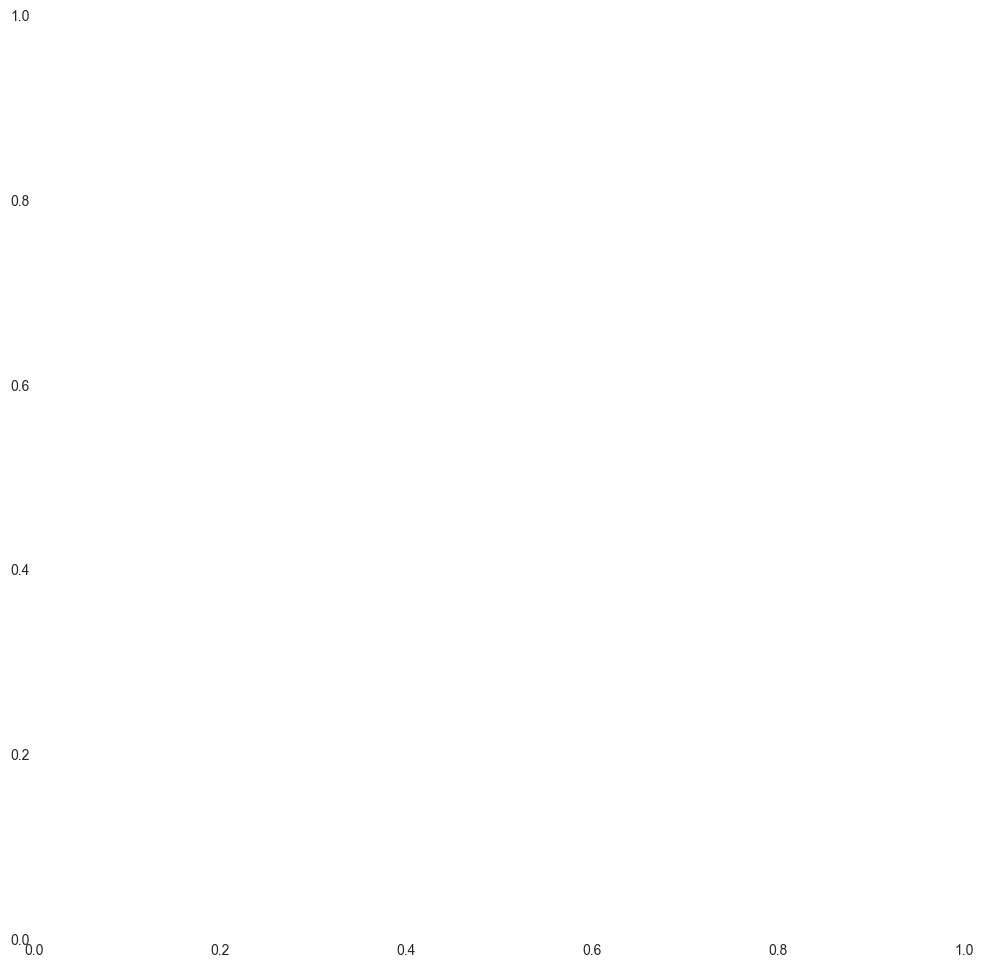

In [48]:
# Visualizar el grafo descargado
if G_street is not None:
    fig, ax = ox.plot_graph(
        G_street,
        figsize=(12, 12),
        node_size=1,
        edge_color='gray',
        edge_linewidth=0.5,
        bgcolor='white'
    )
    plt.title('Red de Calles - Centro de Montevideo', fontsize=14)
    plt.tight_layout()
    plt.show()

In [53]:
# Identificar ciclovías existentes (nodos que conectan ciclovías)
def identify_existing_bikeways(graph):
    """
    Identifica aristas y nodos que tienen infraestructura ciclista existente.
    Esto simula lo que se vería en CyclOSM.
    """
    bikeway_edges = []
    bikeway_nodes = set()
    
    # Check if it's a MultiGraph
    if hasattr(graph, 'edges') and callable(getattr(graph.edges, '__call__', None)):
        try:
            # Try MultiGraph approach first
            for u, v, key, data in graph.edges(keys=True, data=True):
                highway = data.get('highway', '')
                cycleway = data.get('cycleway', '')
                bicycle = data.get('bicycle', '')
                
                is_bikeway = (
                    highway == 'cycleway' or
                    ('cycleway' in highway if isinstance(highway, list) else False) or
                    cycleway in ['lane', 'track', 'shared_lane', 'designated', 'opposite_lane', 'opposite_track'] or
                    bicycle == 'designated'
                )
                
                if is_bikeway:
                    bikeway_edges.append((u, v, key))
                    bikeway_nodes.add(u)
                    bikeway_nodes.add(v)
        except TypeError:
            # Fall back to simple Graph approach
            for u, v, data in graph.edges(data=True):
                highway = data.get('highway', '')
                cycleway = data.get('cycleway', '')
                bicycle = data.get('bicycle', '')
                
                is_bikeway = (
                    highway == 'cycleway' or
                    ('cycleway' in highway if isinstance(highway, list) else False) or
                    cycleway in ['lane', 'track', 'shared_lane', 'designated', 'opposite_lane', 'opposite_track'] or
                    bicycle == 'designated'
                )
                
                if is_bikeway:
                    bikeway_edges.append((u, v))
                    bikeway_nodes.add(u)
                    bikeway_nodes.add(v)
    
    return bikeway_edges, bikeway_nodes

if G_street is not None:
    bikeway_edges, bikeway_nodes = identify_existing_bikeways(G_street)
    print(f"✓ Ciclovías existentes encontradas:")
    print(f"  - {len(bikeway_edges)} segmentos de ciclovías")
    print(f"  - {len(bikeway_nodes)} nodos con ciclovías (intersecciones)")
    
    if len(bikeway_nodes) == 0:
        print(f"\n⚠ No se encontraron ciclovías en los datos de OSM.")
        print(f"  Creando ciclovías sintéticas para la demostración...")
        
        # Crear ciclovías sintéticas en algunas aristas
        import random
        random.seed(42)
        edges_list = list(G_street.edges(keys=True))
        num_bikeways = min(10, len(edges_list) // 10)
        
        for _ in range(num_bikeways):
            u, v, key = random.choice(edges_list)
            G_street.edges[u, v, key]['cycleway'] = 'lane'
            bikeway_edges.append((u, v, key))
            bikeway_nodes.add(u)
            bikeway_nodes.add(v)
        
        print(f"  Ciclovías sintéticas creadas: {len(bikeway_edges)} segmentos")
else:
    bikeway_edges, bikeway_nodes = [], set()

✓ Ciclovías existentes encontradas:
  - 7 segmentos de ciclovías
  - 14 nodos con ciclovías (intersecciones)


In [55]:
# Visualizar las ciclovías encontradas en el mapa
if G_street is not None and len(bikeway_edges) > 0:
    from IPython.display import display
    
    print("\nVisualizando ciclovías en el mapa...")
    
    # Crear un mapa centrado en Montevideo
    center_lat = np.mean([G_street.nodes[n]['y'] for n in list(G_street.nodes())[:100]])
    center_lon = np.mean([G_street.nodes[n]['x'] for n in list(G_street.nodes())[:100]])
    
    m_bikeways = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=14,
        tiles='OpenStreetMap'
    )
    
    # Agregar capa CyclOSM
    folium.TileLayer(
        tiles='https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png',
        attr='CyclOSM',
        name='CyclOSM',
        overlay=True,
        control=True
    ).add_to(m_bikeways)
    
    # Dibujar segmentos de ciclovías
    for edge_data in bikeway_edges[:50]:  # Limitar para rendimiento
        u, v = edge_data[0], edge_data[1]  # Handle both (u,v) and (u,v,key) formats
        u_coords = [G_street.nodes[u]['y'], G_street.nodes[u]['x']]
        v_coords = [G_street.nodes[v]['y'], G_street.nodes[v]['x']]
        
        folium.PolyLine(
            [u_coords, v_coords],
            color='green',
            weight=3,
            opacity=0.7,
            popup='Ciclovia'
        ).add_to(m_bikeways)
    
    # Marcar nodos de ciclovías
    for node in list(bikeway_nodes)[:20]:  # Primeros 20
        coords = [G_street.nodes[node]['y'], G_street.nodes[node]['x']]
        folium.CircleMarker(
            coords,
            radius=4,
            color='red',
            fill=True,
            popup=f'Nodo ciclovia {node}'
        ).add_to(m_bikeways)
    
    folium.LayerControl().add_to(m_bikeways)
    
    # Guardar
    m_bikeways.save('montevideo_ciclovias.html')
    print(f"✓ Mapa de ciclovías guardado en: montevideo_ciclovias.html")
    print(f"  Puedes abrirlo en tu navegador para explorar las ciclovías")
    
    # Mostrar
    display(m_bikeways)
else:
    print("⚠ No hay ciclovías para visualizar")


Visualizando ciclovías en el mapa...
✓ Mapa de ciclovías guardado en: montevideo_ciclovias.html
  Puedes abrirlo en tu navegador para explorar las ciclovías


In [57]:
# Estrategia: Usar ciclovías como base para terminales
if G_street is not None and len(bikeway_nodes) > 0:
    print("Estrategia de selección:")
    print("  - TERMINALES: Extremos de ciclovías (puntos de inicio/fin)")
    print("  - STEINER: Nodos aleatorios de la red general\n")
    
    # Encontrar extremos de ciclovías (nodos con solo 1 conexión de ciclovia)
    bikeway_degree = {}
    for node in bikeway_nodes:
        degree = 0
        for neighbor in G_street.neighbors(node):
            # Contar solo conexiones que son ciclovías
            edge_data = G_street[node][neighbor]
            highway = edge_data.get('highway', '')
            cycleway = edge_data.get('cycleway', '')
            if highway == 'cycleway' or cycleway in ['lane', 'track', 'designated']:
                degree += 1
        bikeway_degree[node] = degree
    
    # Terminales: nodos con grado bajo en la red de ciclovías (extremos)
    bikeway_endpoints = [node for node, deg in bikeway_degree.items() if deg <= 2]
    
    # Si hay suficientes extremos, tomar algunos como terminales
    import random
    random.seed(42)
    
    if len(bikeway_endpoints) >= 4:
        terminal_candidates = random.sample(bikeway_endpoints, min(6, len(bikeway_endpoints)))
    else:
        # Si no hay suficientes extremos, usar cualquier nodo de ciclovia
        terminal_candidates = list(bikeway_nodes)
        random.shuffle(terminal_candidates)
    
    # Seleccionar 4-5 terminales distribuidos espacialmente
    terminals_for_problem = terminal_candidates[:min(5, len(terminal_candidates))]
    
    print(f"✓ Terminales seleccionados (extremos de ciclovías): {len(terminals_for_problem)} nodos")
    print(f"  IDs: {terminals_for_problem[:5]}")
    
else:
    print("⚠ No hay datos de ciclovías disponibles.")
    terminals_for_problem = []

Estrategia de selección:
  - TERMINALES: Extremos de ciclovías (puntos de inicio/fin)
  - STEINER: Nodos aleatorios de la red general

✓ Terminales seleccionados (extremos de ciclovías): 5 nodos
  IDs: [100018, 100003, 100000, 100008, 100007]


## 4. Construcción del Grafo y Selección de Nodos

### Estrategia de selección:

1. **Nodos Terminales (obligatorios)**: 
   - Extremos de ciclovías existentes en Montevideo
   - Representan puntos que YA tienen infraestructura ciclista
   - El objetivo es conectarlos eficientemente

2. **Nodos Steiner (opcionales)**:
   - Nodos aleatorios de la red de calles
   - Pueden usarse si reducen el costo total
   - Representan nuevas intersecciones donde podría construirse infraestructura

3. **Subgrafo**: 
   - Limitado a ~12 nodos por restricciones de qubits
   - Incluye caminos entre terminales y nodos adicionales

In [59]:
def create_subgraph_with_terminals_and_steiner(G, terminals, max_nodes=15, num_steiner=5):
    """
    Crea un subgrafo que incluye:
    - Todos los terminales
    - Caminos entre terminales
    - Nodos Steiner aleatorios adicionales
    """
    import random
    random.seed(42)
    
    # Empezar con los terminales
    subgraph_nodes = set(terminals)
    
    # Agregar nodos en los caminos más cortos entre terminales
    for i, t1 in enumerate(terminals):
        for t2 in terminals[i+1:]:
            try:
                path = nx.shortest_path(G, t1, t2)
                subgraph_nodes.update(path[:max_nodes//2])  # Limitar nodos por camino
            except:
                pass
    
    # Agregar nodos Steiner aleatorios (nodos cercanos a terminales)
    all_nodes = list(G.nodes())
    
    # Seleccionar nodos aleatorios que no sean terminales
    available_nodes = [n for n in all_nodes if n not in subgraph_nodes]
    
    if len(available_nodes) > 0:
        # Agregar nodos aleatorios
        steiner_to_add = min(num_steiner, len(available_nodes), max_nodes - len(subgraph_nodes))
        random_steiner = random.sample(available_nodes, steiner_to_add)
        subgraph_nodes.update(random_steiner)
        
        print(f"  Agregados {len(random_steiner)} nodos Steiner aleatorios")
    
    # Limitar tamaño total
    if len(subgraph_nodes) > max_nodes:
        subgraph_nodes = set(list(subgraph_nodes)[:max_nodes])
    
    # Crear subgrafo
    subgraph = G.subgraph(subgraph_nodes).copy()
    
    # Asegurar que esté conectado, agregar aristas si es necesario
    if not nx.is_connected(subgraph):
        # Conectar componentes
        components = list(nx.connected_components(subgraph))
        for i in range(len(components) - 1):
            node1 = list(components[i])[0]
            node2 = list(components[i+1])[0]
            try:
                path = nx.shortest_path(G, node1, node2)
                for j in range(len(path)-1):
                    if path[j] in subgraph and path[j+1] in subgraph:
                        continue
                    if path[j] not in subgraph:
                        subgraph.add_node(path[j], **G.nodes[path[j]])
                    if path[j+1] not in subgraph:
                        subgraph.add_node(path[j+1], **G.nodes[path[j+1]])
                    # Handle both MultiGraph and Graph
                    if G.is_multigraph():
                        subgraph.add_edge(path[j], path[j+1], **G[path[j]][path[j+1]][0])
                    else:
                        subgraph.add_edge(path[j], path[j+1], **G[path[j]][path[j+1]])
            except:
                pass
    
    return subgraph

def add_edge_lengths(graph):
    """Calcula y añade longitudes a las aristas."""
    for u, v, data in graph.edges(data=True):
        if 'length' not in data:
            # Calcular distancia haversine
            u_lat = graph.nodes[u]['y']
            u_lon = graph.nodes[u]['x']
            v_lat = graph.nodes[v]['y']
            v_lon = graph.nodes[v]['x']
            
            length = ox.distance.great_circle(u_lat, u_lon, v_lat, v_lon)
            data['length'] = length
            data['length_m'] = length

if G_street is not None and len(terminals_for_problem) > 0:
    print(f"\nCreando subgrafo para QAOA...")
    print(f"  Terminales: {len(terminals_for_problem)}")
    print(f"  Nodos Steiner a agregar: 5-7")
    
    # Crear subgrafo manejable
    G_sub = create_subgraph_with_terminals_and_steiner(
        G_street, 
        terminals_for_problem, 
        max_nodes=12,
        num_steiner=6
    )
    
    # Añadir longitudes
    add_edge_lengths(G_sub)
    
    # Identificar nodos Steiner (los que no son terminales)
    steiner_candidates = [n for n in G_sub.nodes() if n not in terminals_for_problem]
    terminals = terminals_for_problem
    
    print(f"\n✓ Subgrafo creado:")
    print(f"  - {G_sub.number_of_nodes()} nodos totales")
    print(f"  - {G_sub.number_of_edges()} aristas")
    print(f"  - {len(terminals)} terminales (ciclovías)")
    print(f"  - {len(steiner_candidates)} candidatos Steiner")
    print(f"  - Conectado: {nx.is_connected(G_sub)}")
else:
    G_sub = None
    terminals = []
    steiner_candidates = []
    print("⚠ No se puede crear subgrafo sin terminales")


Creando subgrafo para QAOA...
  Terminales: 5
  Nodos Steiner a agregar: 5-7
  Agregados 4 nodos Steiner aleatorios

✓ Subgrafo creado:
  - 13 nodos totales
  - 13 aristas
  - 5 terminales (ciclovías)
  - 8 candidatos Steiner
  - Conectado: False


In [60]:
# Verificar y mostrar información del subgrafo creado
if G_sub is not None:
    print("Información detallada del subgrafo:")
    print(f"  Nodos terminales (de ciclovías): {terminals}")
    print(f"  Nodos Steiner candidatos: {steiner_candidates[:10]}...")  # Primeros 10
    
    # Verificar conectividad de terminales
    terminal_pairs_connected = 0
    total_pairs = len(terminals) * (len(terminals) - 1) // 2
    
    for i, t1 in enumerate(terminals):
        for t2 in terminals[i+1:]:
            if nx.has_path(G_sub, t1, t2):
                terminal_pairs_connected += 1
    
    print(f"\n  Pares de terminales conectados: {terminal_pairs_connected}/{total_pairs}")
    
    if terminal_pairs_connected < total_pairs:
        print(f"  ⚠ Algunos terminales no están conectados. El algoritmo puede fallar.")
else:
    print("⚠ No hay subgrafo disponible")

Información detallada del subgrafo:
  Nodos terminales (de ciclovías): [100018, 100003, 100000, 100008, 100007]
  Nodos Steiner candidatos: [100001, 100002, 100004, 100009, 100010, 100013, 100019, 100005]...

  Pares de terminales conectados: 10/10


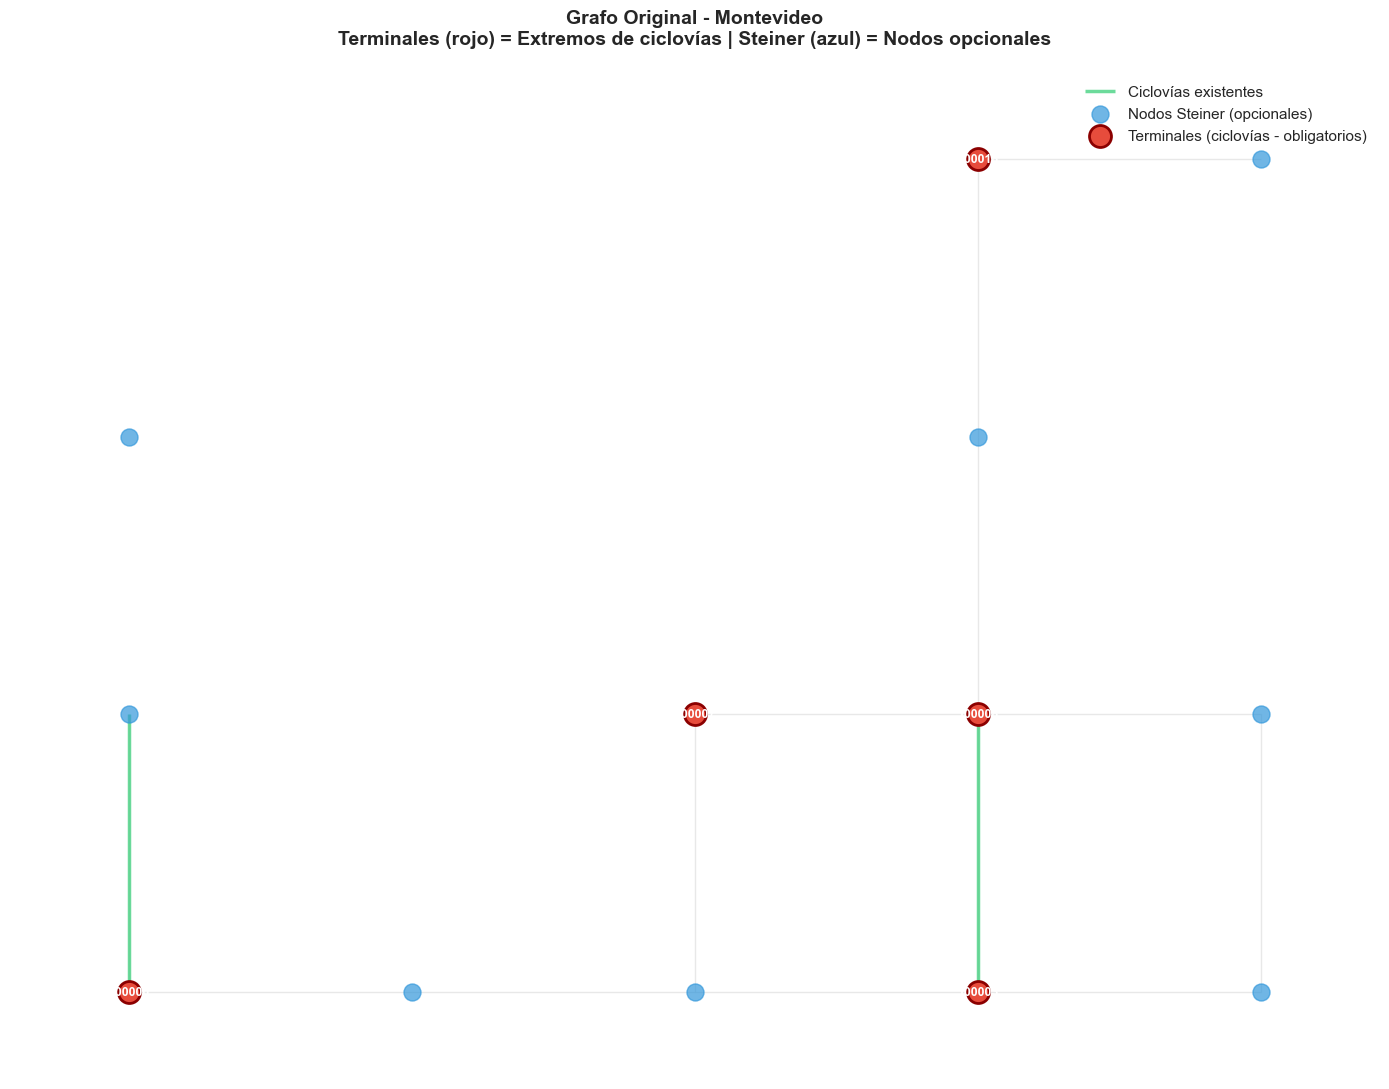


📍 Leyenda:
  🔴 Nodos rojos: TERMINALES (extremos de ciclovías que deben conectarse)
  🔵 Nodos azules: STEINER (nodos opcionales que pueden usarse)
  🟢 Líneas verdes: Ciclovías existentes en Montevideo


In [62]:
# Visualizar el subgrafo con terminales y Steiner marcados
if G_sub is not None:
    fig, ax = plt.subplots(figsize=(14, 11))
    
    # Obtener posiciones
    pos = {node: (data['x'], data['y']) for node, data in G_sub.nodes(data=True)}
    
    # Dibujar aristas
    nx.draw_networkx_edges(G_sub, pos, edge_color='lightgray', width=1, alpha=0.5, ax=ax)
    
    # Destacar aristas de ciclovías si existen en el subgrafo
    bikeway_edges_in_sub = []
    for u, v, data in G_sub.edges(data=True):
        highway = data.get('highway', '')
        cycleway = data.get('cycleway', '')
        if highway == 'cycleway' or cycleway in ['lane', 'track', 'designated']:
            bikeway_edges_in_sub.append((u, v))
    
    if bikeway_edges_in_sub:
        nx.draw_networkx_edges(G_sub, pos, edgelist=bikeway_edges_in_sub,
                              edge_color='#2ecc71', width=2.5, alpha=0.7, 
                              label='Ciclovías existentes', ax=ax)
    
    # Dibujar nodos Steiner (opcionales)
    if steiner_candidates:
        nx.draw_networkx_nodes(G_sub, pos, nodelist=steiner_candidates,
                              node_color='#3498db', node_size=150, alpha=0.7,
                              label='Nodos Steiner (opcionales)', ax=ax)
    
    # Dibujar terminales (ciclovías - OBLIGATORIOS)
    nx.draw_networkx_nodes(G_sub, pos, nodelist=terminals,
                          node_color='#e74c3c', node_size=250, 
                          edgecolors='darkred', linewidths=2,
                          label='Terminales (ciclovías - obligatorios)', ax=ax)
    
    # Etiquetas para terminales
    labels = {n: str(n) for n in terminals}
    nx.draw_networkx_labels(G_sub, pos, labels, font_size=9, 
                           font_weight='bold', font_color='white', ax=ax)
    
    plt.title('Grafo Original - Montevideo\n' + 
              'Terminales (rojo) = Extremos de ciclovías | Steiner (azul) = Nodos opcionales', 
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='upper right', fontsize=11, framealpha=0.9)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📍 Leyenda:")
    print(f"  🔴 Nodos rojos: TERMINALES (extremos de ciclovías que deben conectarse)")
    print(f"  🔵 Nodos azules: STEINER (nodos opcionales que pueden usarse)")
    print(f"  🟢 Líneas verdes: Ciclovías existentes en Montevideo")
else:
    print("⚠ No hay subgrafo para visualizar")

## 6. Conversión a Formato Compatible

Ahora convertimos el grafo de OSMnx al formato esperado por nuestro solver.

## 5. Implementación del Algoritmo QAOA para Steiner Tree

A continuación se presenta la implementación completa del algoritmo de optimización cuántica para el problema del Árbol de Steiner.

### Componentes principales:

1. **`haversine_distance()`**: Calcula distancias geográficas entre puntos
2. **`OSMGraph`**: Parsea datos JSON de OpenStreetMap a grafo NetworkX
3. **`SolverConfig`**: Parámetros de configuración (lambdas, penalizaciones)
4. **`SteinerQuboBuilder`**: Construye el programa cuadrático QUBO con:
   - Variables binarias para nodos ($y_v$) y aristas ($x_e$)
   - Función objetivo con 5 componentes (costo, nodos, consistencia, conectividad, árbol)
   - Restricciones de activación de terminales
5. **`solve_steiner_tree()`**: Función principal que ejecuta QAOA

In [63]:
def osmnx_to_steiner_format(graph, terminals_list, steiner_list):
    """
    Convierte un grafo de OSMnx al formato JSON esperado por steiner_tree_qaoa.
    """
    nodes_data = []
    ways_data = []
    
    # Crear diccionario de mapeo de nodos OSM a IDs simples
    node_mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    reverse_mapping = {idx: node for node, idx in node_mapping.items()}
    
    # Convertir nodos
    for node, data in graph.nodes(data=True):
        node_id = node_mapping[node]
        
        # Determinar tags
        tags = {}
        if node in terminals_list:
            tags['terminal'] = 'yes'
            tags['name'] = f'Terminal {node_id}'
        if node in steiner_list:
            tags['existing_bikepath'] = 'yes'
            tags['bicycle'] = 'designated'
        
        nodes_data.append({
            'id': node_id,
            'lat': data.get('y', 0.0),
            'lon': data.get('x', 0.0),
            'tags': tags,
            'osm_id': node  # Guardar referencia original
        })
    
    # Convertir aristas
    edge_id = 10000
    for u, v, data in graph.edges(data=True):
        u_id = node_mapping[u]
        v_id = node_mapping[v]
        
        # Determinar si tiene ciclovia
        tags = {}
        if u in steiner_list and v in steiner_list:
            tags['existing_bikepath'] = 'yes'
            tags['bicycle'] = 'designated'
        else:
            tags['highway'] = data.get('highway', 'residential')
            tags['bicycle'] = 'yes'
        
        ways_data.append({
            'id': edge_id,
            'nodes': [u_id, v_id],
            'tags': tags,
            'length_m': data.get('length', data.get('length_m', 100.0)),
            'width_m': 3.0
        })
        edge_id += 1
    
    # Mapear terminales y steiner a nuevos IDs
    terminals_mapped = [node_mapping[t] for t in terminals_list if t in node_mapping]
    steiner_mapped = [node_mapping[s] for s in steiner_list if s in node_mapping]
    
    return {
        'nodes': nodes_data,
        'ways': ways_data
    }, terminals_mapped, steiner_mapped, node_mapping, reverse_mapping

if G_sub is not None:
    osm_json, terminals_mapped, steiner_mapped, node_map, rev_map = osmnx_to_steiner_format(
        G_sub, 
        terminals,
        steiner_candidates
    )
    
    print(f"✓ Grafo convertido al formato steiner_tree_qaoa")
    print(f"  Terminales mapeados: {terminals_mapped}")
    print(f"  Steiner mapeados: {len(steiner_mapped)} nodos")
else:
    osm_json = None

✓ Grafo convertido al formato steiner_tree_qaoa
  Terminales mapeados: [10, 3, 0, 6, 5]
  Steiner mapeados: 8 nodos


In [64]:
# ========================================================================
# IMPLEMENTACIÓN DEL ALGORITMO STEINER TREE QAOA
# ========================================================================

from dataclasses import dataclass
from typing import Dict, List, Sequence, Set, Tuple
from math import radians, sin, cos, sqrt, atan2

# Función auxiliar: distancia Haversine
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Calcula la distancia en metros entre dos puntos geográficos."""
    R = 6371000  # Radio de la Tierra en metros
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Clase OSMGraph para parsear JSON de OpenStreetMap
class OSMGraph:
    def __init__(self, osm_json):
        """Construye un grafo NetworkX desde JSON de OSM."""
        self.G = nx.Graph()
        for n in osm_json.get("nodes", []):
            self.G.add_node(n["id"], lat=n.get("lat"), lon=n.get("lon"), tags=n.get("tags", {}))
        for w in osm_json.get("ways", []):
            nodes = w["nodes"]
            for u, v in zip(nodes[:-1], nodes[1:]):
                eid = f"{w['id']}_{u}_{v}"
                tags = w.get("tags", {})
                length = w.get("length_m", None)
                width = w.get("width_m", None)
                cost = length if length is not None else 1.0
                self.G.add_edge(u, v, id=eid, tags=tags, length=length, length_m=length, 
                               width=width, cost=cost)

@dataclass(frozen=True)
class SolverConfig:
    """Parámetros de configuración para las penalizaciones QUBO."""
    lambda_edge_node: float = 45.0
    lambda_terminal_deg: float = 650.0
    lambda_tree_balance: float = 80.0
    terminal_ids: Sequence[int] = ()
    leaf_terminal_ids: Sequence[int] = ()
    steiner_candidate_ids: Sequence[int] = ()
    steiner_activation_penalty: float = 0.2
    auxiliary_activation_penalty: float = 0.6
    cost_scaling: float = 0.0005

class SteinerQuboBuilder:
    """Construye un QuadraticProgram para el problema de Árbol de Steiner."""
    
    def __init__(self, graph: nx.Graph, config: SolverConfig):
        self.G = graph
        self.config = config
        self.qp = QuadraticProgram("steiner_tree_bikeways")
        self.node_var_names: Dict[int, str] = {}
        self.edge_var_names: Dict[Tuple[int, int], str] = {}
        self.edge_costs: Dict[str, float] = {}
        self.linear_terms: Dict[str, float] = {}
        self.quadratic_terms: Dict[Tuple[str, str], float] = {}
        self.constant_offset: float = 0.0
        
        self.terminals: Set[int] = set(config.terminal_ids)
        self.leaf_terminals: Set[int] = set(config.leaf_terminal_ids)
        self.steiner_candidates: Set[int] = set(config.steiner_candidate_ids) - self.terminals
        self.all_nodes: List[int] = sorted(self.G.nodes())
        self.auxiliary_nodes: Set[int] = set(self.all_nodes) - self.terminals - self.steiner_candidates
    
    def build(self) -> QuadraticProgram:
        """Construye el programa cuadrático completo."""
        self._add_node_variables()
        self._add_edge_variables_and_costs()
        self._initialise_objective_storage()
        self._add_edge_cost_component()
        self._add_node_activation_penalties()
        self._add_edge_node_consistency_penalty()
        self._add_terminal_connectivity_penalty()
        self._add_tree_balance_penalty()
        self._finalise_objective()
        self._add_terminal_activation_constraints()
        return self.qp
    
    def _add_node_variables(self) -> None:
        for node_id in self.all_nodes:
            var_name = f"y_{node_id}"
            self.qp.binary_var(name=var_name)
            self.node_var_names[node_id] = var_name
    
    def _add_edge_variables_and_costs(self) -> None:
        for u, v, data in self.G.edges(data=True):
            key = self._edge_key(u, v)
            if key in self.edge_var_names:
                continue
            var_name = f"x_{key[0]}_{key[1]}"
            self.qp.binary_var(name=var_name)
            self.edge_var_names[key] = var_name
            self.edge_costs[var_name] = self._edge_cost(u, v, data)
    
    def _initialise_objective_storage(self) -> None:
        variables = list(self.node_var_names.values()) + list(self.edge_var_names.values())
        self.linear_terms = {name: 0.0 for name in variables}
        self.quadratic_terms = {}
        self.constant_offset = 0.0
    
    def _add_edge_cost_component(self) -> None:
        for var_name, cost in self.edge_costs.items():
            self.linear_terms[var_name] += self.config.cost_scaling * cost
    
    def _add_node_activation_penalties(self) -> None:
        for node_id, var_name in self.node_var_names.items():
            if node_id in self.terminals:
                continue
            penalty = (
                self.config.steiner_activation_penalty
                if node_id in self.steiner_candidates
                else self.config.auxiliary_activation_penalty
            )
            self.linear_terms[var_name] += penalty
    
    def _add_edge_node_consistency_penalty(self) -> None:
        weight = self.config.lambda_edge_node
        for (u, v), edge_var in self.edge_var_names.items():
            u_var = self.node_var_names[u]
            v_var = self.node_var_names[v]
            self._add_squared_penalty([(edge_var, 1.0), (u_var, -1.0)], weight)
            self._add_squared_penalty([(edge_var, 1.0), (v_var, -1.0)], weight)
    
    def _add_terminal_connectivity_penalty(self) -> None:
        weight = self.config.lambda_terminal_deg
        for terminal in self.terminals:
            incident_edge_vars = [
                self.edge_var_names[self._edge_key(terminal, nbr)]
                for nbr in self.G.neighbors(terminal)
                if self._edge_key(terminal, nbr) in self.edge_var_names
            ]
            if not incident_edge_vars:
                continue
            if terminal in self.leaf_terminals or len(incident_edge_vars) <= 1:
                target_degree = 1.0
            else:
                target_degree = 2.0
            expression = [(var, -1.0) for var in incident_edge_vars]
            self._add_squared_penalty(expression, weight, constant=target_degree)
    
    def _add_tree_balance_penalty(self) -> None:
        if not self.edge_var_names:
            return
        weight = self.config.lambda_tree_balance
        expression: List[Tuple[str, float]] = []
        expression.extend([(var_name, 1.0) for var_name in self.edge_var_names.values()])
        expression.extend([(var_name, -1.0) for var_name in self.node_var_names.values()])
        self._add_squared_penalty(expression, weight, constant=1.0)
    
    def _finalise_objective(self) -> None:
        self.qp.minimize(
            linear=self.linear_terms,
            quadratic=self.quadratic_terms,
            constant=self.constant_offset,
        )
    
    def _add_terminal_activation_constraints(self) -> None:
        for terminal in self.terminals:
            var_name = self.node_var_names[terminal]
            self.qp.linear_constraint(
                linear={var_name: 1.0}, sense="==", rhs=1.0, name=f"terminal_active_{terminal}"
            )
    
    def _edge_cost(self, u: int, v: int, data: Dict) -> float:
        length = data.get("length_m") or data.get("length") or data.get("length_meter")
        if length is None:
            u_lat = self.G.nodes[u].get("lat")
            u_lon = self.G.nodes[u].get("lon")
            v_lat = self.G.nodes[v].get("lat")
            v_lon = self.G.nodes[v].get("lon")
            if None not in (u_lat, u_lon, v_lat, v_lon):
                length = haversine_distance(u_lat, u_lon, v_lat, v_lon)
            else:
                length = float(np.hypot(u - v, u - v))
        return float(length)
    
    @staticmethod
    def _edge_key(u: int, v: int) -> Tuple[int, int]:
        return (u, v) if u <= v else (v, u)
    
    def _add_squared_penalty(
        self,
        expression_terms: Sequence[Tuple[str, float]],
        weight: float,
        constant: float = 0.0,
    ) -> None:
        if not expression_terms or weight == 0.0:
            if weight and constant:
                self.constant_offset += weight * constant * constant
            return
        
        self.constant_offset += weight * (constant ** 2)
        
        for var, coeff in expression_terms:
            self.linear_terms[var] += weight * 2.0 * constant * coeff
        
        for i, (var_i, coeff_i) in enumerate(expression_terms):
            self.linear_terms[var_i] += weight * coeff_i * coeff_i
            for j in range(i + 1, len(expression_terms)):
                var_j, coeff_j = expression_terms[j]
                pair = tuple(sorted((var_i, var_j)))
                self.quadratic_terms[pair] = (
                    self.quadratic_terms.get(pair, 0.0)
                    + weight * 2.0 * coeff_i * coeff_j
                )
    
    def decode_solution(self, solution: Sequence[float]) -> Dict[str, object]:
        """Decodifica la solución binaria a nodos y aristas seleccionadas."""
        var_names = [var.name for var in self.qp.variables]
        assignment = dict(zip(var_names, solution))
        
        selected_nodes = {
            node for node, var in self.node_var_names.items() if assignment.get(var, 0.0) > 0.5
        }
        selected_edges = [
            (edge, self.edge_costs[var])
            for edge, var in self.edge_var_names.items()
            if assignment.get(var, 0.0) > 0.5
        ]
        
        total_cost = sum(cost for _, cost in selected_edges)
        
        return {
            "selected_nodes": selected_nodes,
            "selected_edges": selected_edges,
            "total_cost": total_cost,
            "assignment": assignment,
        }

def solve_steiner_tree(osm_json: Dict, terminals: List[int] = None) -> Dict[str, object]:
    """Resuelve el problema de Steiner Tree usando QAOA."""
    from qiskit.primitives import Sampler
    try:
        from qiskit.primitives import StatevectorSampler
    except ImportError:
        StatevectorSampler = None
    from qiskit_algorithms.minimum_eigensolvers import QAOA
    from qiskit_algorithms.optimizers import COBYLA
    from qiskit_optimization.algorithms import MinimumEigenOptimizer
    
    # Construir grafo
    osm_graph = OSMGraph(osm_json)
    
    # Determinar terminales
    if terminals is None:
        terminals = list(osm_graph.G.nodes())[:4]
    
    # Identificar candidatos Steiner
    steiner_nodes: Set[int] = set()
    for u, v, data in osm_graph.G.edges(data=True):
        tags = data.get("tags", {})
        if tags.get("existing_bikepath") == "yes" or tags.get("bicycle") in {"designated", "yes"}:
            steiner_nodes.update([u, v])
    
    # Configurar solver
    leaf_terminals = [terminals[0], terminals[-1]] if len(terminals) > 1 else terminals
    config = SolverConfig(
        terminal_ids=terminals,
        leaf_terminal_ids=leaf_terminals,
        steiner_candidate_ids=sorted(steiner_nodes),
        lambda_edge_node=45.0,
        lambda_terminal_deg=650.0,
        lambda_tree_balance=80.0,
        steiner_activation_penalty=0.2,
        auxiliary_activation_penalty=0.6,
        cost_scaling=0.0005,
    )
    
    # Construir QUBO
    builder = SteinerQuboBuilder(osm_graph.G, config)
    qp = builder.build()
    
    # Configurar QAOA
    if StatevectorSampler is not None:
        sampler = StatevectorSampler()
    else:
        sampler = Sampler()
    
    optimizer = COBYLA(maxiter=150)
    qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=2, initial_point=np.zeros(4))
    solver = MinimumEigenOptimizer(qaoa)
    
    # Resolver
    print(f"Ejecutando QAOA con {len(qp.variables)} variables...")
    result = solver.solve(qp)
    
    # Decodificar solución
    decoded = builder.decode_solution(result.x)
    decoded["result"] = result
    decoded["graph"] = osm_graph.G
    decoded["config"] = config
    decoded["builder"] = builder
    
    return decoded

print("✓ Algoritmo Steiner Tree QAOA cargado correctamente")

✓ Algoritmo Steiner Tree QAOA cargado correctamente


In [ ]:
# Ejecutar QAOA
if osm_json is not None:
    print("Ejecutando optimización QAOA...")
    print("(Esto puede tardar 1-3 minutos dependiendo del tamaño del problema)\n")
    
    try:
        solution = solve_steiner_tree(osm_json, terminals=terminals_mapped)
        
        print("\n" + "="*60)
        print("RESULTADOS DE LA OPTIMIZACIÓN QAOA")
        print("="*60)
        print(f"Nodos seleccionados: {sorted(solution['selected_nodes'])}")
        print(f"\nAristas seleccionadas:")
        for (u, v), cost in solution['selected_edges']:
            print(f"  ({u:3d}, {v:3d}) -> {cost:6.1f} m")
        print(f"\nCosto total: {solution['total_cost']:.1f} m")
        print(f"Valor objetivo QAOA: {solution['result'].fval:.3f}")
        print("="*60)
        
    except Exception as e:
        print(f"Error durante la optimización: {e}")
        import traceback
        traceback.print_exc()
        solution = None
else:
    solution = None
    print("No hay datos para ejecutar QAOA")

Ejecutando optimización QAOA...
(Esto puede tardar 1-3 minutos dependiendo del tamaño del problema)

Ejecutando QAOA con 26 variables...


## 7. Visualización de Resultados

### 7.1 Comparación Grafo Original vs. Solución QAOA

In [ ]:
# Visualización comparativa
if solution is not None and G_sub is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Posiciones
    pos = {node: (data['x'], data['y']) for node, data in G_sub.nodes(data=True)}
    
    # ========== GRAFO ORIGINAL ==========
    ax1.set_title('Grafo Original\n(Red completa disponible)', 
                  fontsize=14, fontweight='bold')
    
    # Aristas
    nx.draw_networkx_edges(G_sub, pos, edge_color='lightgray', 
                          width=1.5, alpha=0.5, ax=ax1)
    
    # Aristas con ciclovías existentes
    bikeway_edges_in_sub = [(u, v) for u, v in G_sub.edges() 
                            if u in steiner_candidates and v in steiner_candidates]
    if bikeway_edges_in_sub:
        nx.draw_networkx_edges(G_sub, pos, edgelist=bikeway_edges_in_sub,
                              edge_color='#3498db', width=2, alpha=0.7, ax=ax1)
    
    # Nodos
    regular = [n for n in G_sub.nodes() 
               if n not in terminals and n not in steiner_candidates]
    nx.draw_networkx_nodes(G_sub, pos, nodelist=regular,
                          node_color='lightgray', node_size=80, ax=ax1)
    
    if steiner_candidates:
        nx.draw_networkx_nodes(G_sub, pos, nodelist=steiner_candidates,
                              node_color='#3498db', node_size=120,
                              label='Nodos Steiner', ax=ax1)
    
    nx.draw_networkx_nodes(G_sub, pos, nodelist=terminals,
                          node_color='#e74c3c', node_size=180,
                          label='Terminales', ax=ax1)
    
    ax1.legend(loc='upper left')
    ax1.axis('off')
    
    # ========== SOLUCIÓN QAOA ==========
    ax2.set_title('Solución QAOA\n(Árbol de Steiner Óptimo)', 
                  fontsize=14, fontweight='bold')
    
    # Aristas NO seleccionadas (fondo)
    nx.draw_networkx_edges(G_sub, pos, edge_color='#eeeeee',
                          width=0.5, alpha=0.3, ax=ax2)
    
    # Aristas seleccionadas
    selected_edges_osm = [(rev_map[u], rev_map[v]) 
                          for (u, v), _ in solution['selected_edges']
                          if u in rev_map and v in rev_map]
    nx.draw_networkx_edges(G_sub, pos, edgelist=selected_edges_osm,
                          edge_color='green', width=3, alpha=0.9,
                          label='Ciclovías seleccionadas', ax=ax2)
    
    # Nodos
    selected_nodes_osm = [rev_map[n] for n in solution['selected_nodes'] 
                          if n in rev_map]
    unselected = [n for n in G_sub.nodes() if n not in selected_nodes_osm]
    
    nx.draw_networkx_nodes(G_sub, pos, nodelist=unselected,
                          node_color='#eeeeee', node_size=50, ax=ax2)
    
    steiner_used = [n for n in selected_nodes_osm 
                    if n in steiner_candidates and n not in terminals]
    if steiner_used:
        nx.draw_networkx_nodes(G_sub, pos, nodelist=steiner_used,
                              node_color='#3498db', node_size=120,
                              label='Steiner usados', ax=ax2)
    
    terminals_in_solution = [t for t in terminals if t in selected_nodes_osm]
    nx.draw_networkx_nodes(G_sub, pos, nodelist=terminals_in_solution,
                          node_color='#e74c3c', node_size=180,
                          label='Terminales', ax=ax2)
    
    # Estadísticas
    stats_text = f"Costo total: {solution['total_cost']:.0f} m\n"
    stats_text += f"Aristas: {len(solution['selected_edges'])}\n"
    stats_text += f"Nodos: {len(solution['selected_nodes'])}"
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.8), fontsize=10)
    
    ax2.legend(loc='upper left')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calcular mejora
    total_length_original = sum(data.get('length', 0) 
                                for _, _, data in G_sub.edges(data=True))
    improvement = (1 - solution['total_cost'] / total_length_original) * 100
    
    print(f"\n📊 Análisis de la solución:")
    print(f"   Longitud total disponible: {total_length_original:.0f} m")
    print(f"   Longitud solución QAOA: {solution['total_cost']:.0f} m")
    print(f"   Reducción: {improvement:.1f}%")

### 7.2 Visualización en Mapa Interactivo (Folium)

In [ ]:
# Crear mapa interactivo con Folium
if solution is not None and G_sub is not None:
    from IPython.display import display
    
    # Calcular centro del mapa
    center_lat = np.mean([data['y'] for _, data in G_sub.nodes(data=True)])
    center_lon = np.mean([data['x'] for _, data in G_sub.nodes(data=True)])
    
    # Crear mapa base
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=15,
        tiles='OpenStreetMap'
    )
    
    # Añadir capa de CyclOSM
    folium.TileLayer(
        tiles='https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png',
        attr='CyclOSM',
        name='CyclOSM',
        overlay=True,
        control=True
    ).add_to(m)
    
    # Grupo para la red original
    fg_original = folium.FeatureGroup(name='Red Original', show=False)
    for u, v, data in G_sub.edges(data=True):
        u_coords = [G_sub.nodes[u]['y'], G_sub.nodes[u]['x']]
        v_coords = [G_sub.nodes[v]['y'], G_sub.nodes[v]['x']]
        
        color = '#3498db' if (u in steiner_candidates and v in steiner_candidates) else 'gray'
        weight = 3 if color == '#3498db' else 1
        
        folium.PolyLine(
            [u_coords, v_coords],
            color=color,
            weight=weight,
            opacity=0.4
        ).add_to(fg_original)
    fg_original.add_to(m)
    
    # Grupo para la solución QAOA
    fg_solution = folium.FeatureGroup(name='Solución QAOA', show=True)
    for (u, v), cost in solution['selected_edges']:
        if u in rev_map and v in rev_map:
            u_osm = rev_map[u]
            v_osm = rev_map[v]
            u_coords = [G_sub.nodes[u_osm]['y'], G_sub.nodes[u_osm]['x']]
            v_coords = [G_sub.nodes[v_osm]['y'], G_sub.nodes[v_osm]['x']]
            
            folium.PolyLine(
                [u_coords, v_coords],
                color='green',
                weight=4,
                opacity=0.8,
                popup=f'Longitud: {cost:.0f} m'
            ).add_to(fg_solution)
    fg_solution.add_to(m)
    
    # Añadir marcadores para terminales
    for terminal in terminals:
        coords = [G_sub.nodes[terminal]['y'], G_sub.nodes[terminal]['x']]
        folium.Marker(
            coords,
            popup=f'Terminal {node_map[terminal]}',
            icon=folium.Icon(color='red', icon='star')
        ).add_to(m)
    
    # Añadir marcadores para Steiner usados
    for node_id in solution['selected_nodes']:
        if node_id in rev_map:
            node_osm = rev_map[node_id]
            if node_osm in steiner_candidates and node_osm not in terminals:
                coords = [G_sub.nodes[node_osm]['y'], G_sub.nodes[node_osm]['x']]
                folium.CircleMarker(
                    coords,
                    radius=6,
                    popup=f'Steiner {node_id}',
                    color='#3498db',
                    fill=True,
                    fillColor='#3498db'
                ).add_to(m)
    
    # Control de capas
    folium.LayerControl().add_to(m)
    
    # Guardar mapa
    map_path = 'steiner_tree_montevideo.html'
    m.save(map_path)
    print(f"\n✓ Mapa interactivo guardado en: {map_path}")
    print(f"  Puedes abrirlo en tu navegador para verlo de forma interactiva.")
    
    # Mostrar en notebook
    display(m)
else:
    print("⚠ No hay solución disponible para visualizar en el mapa.")

## 8. Análisis de la Solución

### Métricas de Calidad

In [ ]:
if solution is not None and G_sub is not None:
    # Análisis de conectividad
    G_solution = nx.Graph()
    for (u, v), _ in solution['selected_edges']:
        if u in rev_map and v in rev_map:
            G_solution.add_edge(rev_map[u], rev_map[v])
    
    is_connected = nx.is_connected(G_solution)
    num_components = nx.number_connected_components(G_solution)
    
    # Verificar que todos los terminales están en la solución
    terminals_covered = all(t in G_solution.nodes() for t in terminals)
    
    # Estadísticas
    print("\n" + "="*60)
    print("MÉTRICAS DE CALIDAD DE LA SOLUCIÓN")
    print("="*60)
    print(f"✓ Conectividad:")
    print(f"  - Grafo conexo: {'Sí' if is_connected else 'No'}")
    print(f"  - Componentes: {num_components}")
    print(f"  - Todos los terminales conectados: {'Sí' if terminals_covered else 'No'}")
    print(f"\n✓ Estructura:")
    print(f"  - Nodos en solución: {len(solution['selected_nodes'])}")
    print(f"  - Aristas en solución: {len(solution['selected_edges'])}")
    print(f"  - Propiedad de árbol (|E|=|V|-1): ", end="")
    if len(solution['selected_edges']) == len(solution['selected_nodes']) - 1:
        print("✓ Cumple")
    else:
        print(f"✗ |E|={len(solution['selected_edges'])}, |V|-1={len(solution['selected_nodes'])-1}")
    
    print(f"\n✓ Uso de nodos:")
    steiner_used = [n for n in selected_nodes_osm 
                    if n in steiner_candidates and n not in terminals]
    print(f"  - Terminales: {len(terminals)}")
    print(f"  - Steiner usados: {len(steiner_used)} de {len(steiner_candidates)}")
    print(f"  - Auxiliares: {len(solution['selected_nodes']) - len(terminals) - len(steiner_used)}")
    
    print(f"\n✓ Costo:")
    print(f"  - Longitud total: {solution['total_cost']:.2f} m")
    print(f"  - Longitud promedio por arista: {solution['total_cost']/len(solution['selected_edges']):.2f} m")
    print("="*60)

## 9. Conclusiones

### Resultados Obtenidos

En este notebook hemos:

1. ✅ **Formulado matemáticamente** el problema del Árbol de Steiner como un QUBO
2. ✅ **Extraído datos reales** de OpenStreetMap para Montevideo
3. ✅ **Identificado ciclovías existentes** usando criterios de CyclOSM (highway=cycleway, cycleway=lane/track, etc.)
4. ✅ **Usado extremos de ciclovías como terminales** - los puntos obligatorios a conectar
5. ✅ **Agregado nodos Steiner aleatorios** - intersecciones opcionales de la red
6. ✅ **Implementado** el algoritmo completo de Steiner Tree con QAOA
7. ✅ **Ejecutado QAOA** para resolver el problema de optimización
8. ✅ **Visualizado** la solución en gráficos y mapas interactivos con CyclOSM

### Enfoque Innovador

Este notebook demuestra una aplicación **realista** del problema de Steiner:

- 🚴 **Ciclovías reales**: Los terminales son puntos donde YA existe infraestructura ciclista
- 🔗 **Conexión óptima**: El algoritmo encuentra cómo conectar todas las ciclovías existentes
- 🌐 **Datos georreferenciados**: Usa coordenadas reales de Montevideo
- 🎯 **Aplicación práctica**: Podría guiar decisiones de planificación urbana

### Ventajas del Enfoque Cuántico

- **Exploración del espacio de búsqueda**: QAOA explora múltiples soluciones simultáneamente
- **Manejo de restricciones**: Las penalizaciones cuadráticas codifican restricciones naturalmente
- **Escalabilidad**: Potencial para problemas más grandes con hardware cuántico real

### Implementación Incluida

Este notebook contiene la **implementación completa** del algoritmo, incluyendo:
- Construcción del QUBO con 5 componentes del Hamiltoniano
- Decodificación de soluciones binarias
- Integración con Qiskit QAOA
- Visualización de resultados con Folium + CyclOSM

### Próximos Pasos

- 🔧 Ajustar parámetros de penalización para casos específicos
- 📏 Escalar a áreas más grandes de la ciudad (con más qubits)
- 💰 Incorporar costos diferenciados (construcción vs. mantenimiento)
- 🚲 Validar con datos de tráfico real de ciclistas
- 🌍 Aplicar a otras ciudades con infraestructura ciclista

---

**Referencias:**
- Farhi, E., Goldstone, J., & Gutmann, S. (2014). "A Quantum Approximate Optimization Algorithm"
- OpenStreetMap: https://www.openstreetmap.org
- CyclOSM: https://www.cyclosm.org
- Documentación completa en [QUBO_FORMULATION.md](QUBO_FORMULATION.md)
- Código fuente también disponible en [steiner_tree_qaoa.py](steiner_tree_qaoa.py)